# MVTec Data Loader Example

## This notebook provides an example on how to use the MVTec data loader to train a binary classifier
## This is a modified version of original https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## Import packages

In [1]:
import torch
import torchvision
import mvtecDataset as md
import torchvision.transforms as transforms

## Data loaders

##############################################################################################
### To use our data loader please download all the MVTec data available at:- 
### https://www.mvtec.com/company/research/datasets/mvtec-ad
### And save them in the folder ./mvtec
##############################################################################################

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 70

# Original images are high resolution, so we resize them using the transformation
# provided by pytorch: https://pytorch.org/vision/stable/transforms.html
im_shape = 64

# Interpolation method for resizing the image
interpol = 3

# Data category to use: carpet, leather, wood, bottle, etc.
cat = 'carpet'

trainset = md.MVTEC(root='mvtec', train=True, transform=transform,
                    resize=im_shape, interpolation=interpol, category=cat)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = md.MVTEC(root='mvtec', train=False, transform=transform,
                    resize=im_shape, interpolation=interpol, category=cat)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

# Each category has two types of images: good (label 1) or defective (label 0)
classes = ('defective', 'good')

## Show one image

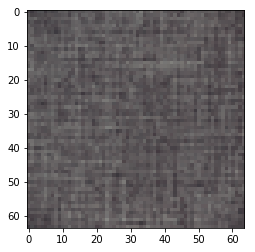

good


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get a random training image
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(images[0])
# print label
print(classes[labels[0]])

## Define a model (Convolutional NN)

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, bias=False, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False, padding=2)
        self.fc1 = nn.Linear(int(16 * (im_shape/4) * (im_shape/4)), 100, bias=False)
        self.fc2 = nn.Linear(100, 10, bias=False)
        self.fc3 = nn.Linear(10, 2, bias=False)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Define a loss function and optimizer

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

## Model training

In [6]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss))
        running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.694
[1,     2] loss: 0.693
[1,     3] loss: 0.693
[1,     4] loss: 0.692
[2,     1] loss: 0.690
[2,     2] loss: 0.688
[2,     3] loss: 0.686
[2,     4] loss: 0.684
[3,     1] loss: 0.681
[3,     2] loss: 0.677
[3,     3] loss: 0.672
[3,     4] loss: 0.666
[4,     1] loss: 0.658
[4,     2] loss: 0.648
[4,     3] loss: 0.633
[4,     4] loss: 0.613
[5,     1] loss: 0.583
[5,     2] loss: 0.540
[5,     3] loss: 0.474
[5,     4] loss: 0.379
Finished Training


## Save model (optional)

In [7]:
#PATH = './cifar_net.pth'
#torch.save(net.state_dict(), PATH)

## Model testing

### Lets see how it works for one test image

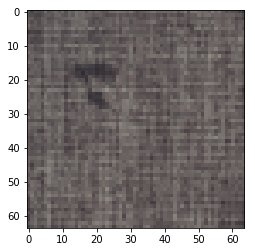

Ground Truth:
defective


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(images[0])
# print label
print('Ground Truth:')
print(classes[labels[0]])

In [9]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted:')
print(classes[predicted[0]])

Predicted:
good


### Testing in the whole testing set

In [10]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 23 %


### Accuracy for each class

In [11]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class defective is: 0.0 %
Accuracy for class good  is: 100.0 %


### The resulting accuracies make sense: the MVTec dataset only provides 'good' training samples, i.e., there are not 'defective' samples in the training set, only on the test set. For the 'carpet' category, the MVTec dataset provides 117 testing samples, 28 'good' and 89 'defective', i.e., 23% of the testing samples are 'good' samples